# PFM Analytics

**Objective:** This notebook focuses on analyzing transaction data to generate personal financial management (PFM) insights for customers.

### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

sns.set_style('whitegrid')

## 1. Data Cleaning and Preparation

First, we load the dataset and perform initial checks to understand its structure, identify missing values, and look for duplicates.

In [ ]:
df = pd.read_csv('pfm_churn_case_study_transactions.csv')

print("Dataset Shape:")
print(df.shape)
print("\nInitial Data Info:")
df.info()

Dataset Shape:
(26793, 19)

Initial Data Info:
<class 'pandas.DataFrame'>
RangeIndex: 26793 entries, 0 to 26792
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_id          26793 non-null  int64  
 1   account_id           26793 non-null  str    
 2   txn_id               26793 non-null  str    
 3   txn_datetime         26660 non-null  str    
 4   txn_type             26793 non-null  str    
 5   amount               26793 non-null  str    
 6   currency             26713 non-null  str    
 7   channel              26793 non-null  str    
 8   merchant_name        25788 non-null  str    
 9   merchant_category    26260 non-null  str    
 10  counterparty_bank    5236 non-null   str    
 11  narration            26793 non-null  str    
 12  city                 25198 non-null  str    
 13  segment              26793 non-null  str    
 14  customer_age         26217 non-null  float64
 15  

In [ ]:
df

,customer_id,account_id,txn_id,txn_datetime,txn_type,amount,currency,channel,merchant_name,merchant_category,counterparty_bank,narration,city,segment,customer_age,onboarding_days_ago,app_logins_30d,support_tickets_90d,churn_next_30d
0,10001,AC100018991,T202508041000100001,2025-08-04 09:20:00,CREDIT,91915.21,PKR,MobileApp,EmployerPayroll,Salary,NaN,Salary credit,Lahore,Retail,26.0,929,17.0,0,0
1,10001,AC100018991,T202508191000100002,2025-08-19 14:02:00,DEBIT,26952.79,PKR,MobileApp,PropertyMgmt,Rent,SCB,Monthly rent,Lahore,Retail,26.0,929,17.0,0,0
2,10001,AC100018991,T202508301000100003,2025-08-30 15:43:00,DEBIT,2935.32,PKR,BillPay,K-Electric,Utilities,NaN,Utility bill payment - K-Electric,Lahore,Retail,26.0,929,17.0,0,0
3,10001,AC100018991,T202508281000100004,2025-08-28 19:51:00,DEBIT,5591.98,PKR,BillPay,SSGC,Utilities,NaN,Utility bill payment - SSGC,Lahore,Retail,26.0,929,17.0,0,0
4,10001,AC100018991,T202508271000100005,2025-08-27 13:42:00,DEBIT,3538.82,PKR,BillPay,PTCL,Utilities,NaN,Utility bill payment - PTCL,Lahore,Retail,26.0,929,17.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26788,10105,AC101051950,T202509131010507033,2025-09-13 10:50:51,DEBIT,4344.3,PKR,ATM,SSGC,Utilities,NaN,Utilities payment,Hyderabad,Retail,40.0,346,14.0,1,0
26789,10201,AC102012663,T202510201020113436,20/10/2025 19:55,DEBIT,1935.42,PKR,IBFT,Cinema,Entertainment,NaN,Entertainment payment,Faisalabad,Affluent,44.0,163,20.0,1,0
26790,10248,AC102487610,T202511041024816483,2025-11-04 22:36:44,DEBIT,697.54,PKR,POS,WASA,Utilities,NaN,Utilities payment,Multan,Retail,18.0,305,20.0,3,0
26791,10289,AC102896094,T202508251028919169,2025-08-25 17:15:00,DEBIT,7558.03,PKR,BillPay,PTCL,Utilities,NaN,Utility bill payment - PTCL,Rawalpindi,Retail,33.0,508,21.0,0,1


### 1.1. Clean `txn_datetime`

This section addresses issues with the `txn_datetime` column, which contains mixed date-time formats and some invalid entries.

#### Strategy for `txn_datetime` Cleaning:

**Technique Used: `pd.to_datetime()` with `errors='coerce'`**

**Why this approach?**
- **Handles mixed formats automatically:** The dataset contains dates in multiple formats (ISO 8601, DD/MM/YYYY, etc.). `pd.to_datetime()` intelligently parses most common formats without manual specification.
- **`errors='coerce'` parameter:** Converts unparseable dates to `NaT` (Not a Time) instead of raising errors, allowing the cleaning process to continue.

**Alternative approaches considered:**
- ❌ **Manual parsing with `datetime.strptime()`:** Would require identifying all date formats first and applying different parsers - too brittle and time-consuming.

**Why drop NaT values instead of imputing?**
- **Time is critical for analysis:** Transaction datetime is essential for frequency features, cashflow trends, and activity patterns.
- **Imputation is speculative:** No reliable way to guess when a transaction occurred without introducing significant bias.
- **Data quality signal:** NaT values indicate data quality issues; dropping them is safer than propagating errors.


In [ ]:
print(f"Null txn_datetime before cleaning: {df['txn_datetime'].isnull().sum()}")
df['txn_datetime'] = pd.to_datetime(df['txn_datetime'], errors='coerce')
print(f"Null txn_datetime after initial conversion: {df['txn_datetime'].isnull().sum()}")
df.dropna(subset=['txn_datetime'], inplace=True)

Null txn_datetime before cleaning: 133
Null txn_datetime after initial conversion: 5633


### 1.2. Clean `amount` and `txn_type`

This section handles inconsistencies in `txn_type` (casing) and `amount` (non-numeric values, commas, sign logic).

#### Strategy for `amount` and `txn_type` Cleaning:

**Technique 1: `pd.to_numeric()` with `errors='coerce'` for amount cleaning**

**Why this approach?**
- **Handles multiple data quality issues:** Removes commas (e.g., '1,000'), strips whitespace, and converts to numeric type in one pipeline.
- **`errors='coerce'` parameter:** Converts unparseable values (e.g., 'N/A', 'null', corrupted text) to `NaN` instead of crashing.
- **Preserves valid data:** Only marks truly invalid entries as `NaN`, keeping all parseable numbers.


**Technique 2: Drop NaN amounts instead of imputation**

**Why drop instead of impute?**
- **Financial data is critical:** Transaction amounts are the core of PFM analysis; wrong values corrupt all downstream metrics.
- **No reliable imputation strategy:** Cannot guess transaction amounts without introducing massive bias.
- **Preserves data integrity:** Better to have fewer accurate records than more records with fabricated values.

**Alternative imputation methods (NOT used):**
- ✗ **Mean/median imputation:** Would create artificial transactions at average values; distorts spending patterns.
- ✗ **Category-based imputation:** Still speculative; no way to know actual transaction value.

**Technique 3: `np.where()` for sign logic**

**Why this approach?**
- **Vectorized operation:** Much faster than row-by-row loops or `.apply()`.
- **Clear business logic:** Explicitly enforces that debits are negative, credits are positive.
- **Handles inconsistent signs:** Takes absolute value first, then applies correct sign based on transaction type.


In [ ]:
df['txn_type'] = df['txn_type'].str.lower()
df['amount'] = df['amount'].astype(str).str.replace(',', '').str.strip()
df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
df.dropna(subset=['amount'], inplace=True)
df['amount'] = np.where(df['txn_type'] == 'debit', -np.abs(df['amount']), np.abs(df['amount']))
print("Amount column summary after cleaning:")
print(df['amount'].describe())

Amount column summary after cleaning:
count     21160.000000
mean       5522.749851
std       37555.859720
min     -156653.650000
25%       -7555.547500
50%       -3754.105000
75%        -552.557500
max      339422.510000
Name: amount, dtype: float64


### 1.3. Standardize Categorical Fields

This section focuses on cleaning and standardizing various categorical columns (`currency`, `merchant_category`, `city`, `segment`) by addressing casing, misspellings, abbreviations, and null values.

**Technique 1: `.str.upper()` for currency standardization**

**Why uppercase?**
- **ISO 4217 standard:** Currency codes are officially uppercase (PKR, USD, EUR).
- **Consistency:** Prevents 'PKR', 'pkr', 'Pkr' from being treated as different categories.

**Alternatives considered:**
- ✗ **`.str.lower()`:** Not standard for currency codes.
- ✗ **`.str.title()`:** Would create 'Pkr' which is non-standard.

**Technique 2: `fillna('PKR')` for missing currency**

**Why fill with 'PKR'?**
- **Domain knowledge:** This is a Pakistani digital bank; PKR is the dominant currency (likely >95%).
- **Safe assumption:** Missing currency in this context almost certainly means PKR.


**Technique 3: Dictionary mapping for city abbreviations**

**Why dictionary mapping?**
- **Explicit control:** Clear mapping of known abbreviations (KHI→Karachi, LHE→Lahore, ISB→Islamabad).
- **Preserves unknowns:** Only changes known abbreviations; leaves other values intact.
- **Readable:** Easy to understand and maintain.


**Technique 4: `fillna('Unknown')` for merchant_category and city**

**Why 'Unknown' instead of mode?**
- **Preserves information:** 'Missing' is itself informative; might correlate with churn or specific behaviors.
- **Avoids false associations:** Mode imputation would artificially inflate the most common category.
- **Explicit handling:** Makes it clear in analysis that these values were originally missing.


**Technique 5: Mode imputation for `segment`**

**Why mode for segment but 'Unknown' for others?**
- **Customer-level attribute:** Segment is a property of the customer, not the transaction.
- **Likely data entry issue:** Missing segment is probably a data quality issue, not meaningful missingness.
- **Model compatibility:** Many ML models work better without 'Unknown' categories in key demographic fields.


#### Strategy for Categorical Field Cleaning:
- **`currency`:** Standardize to uppercase and fill null values with 'PKR'. Justification: As PKR is the predominant currency, filling the few nulls with the mode is a safe and common practice.
- **`merchant_category`:** Fix known misspellings (e.g., 'Grocerries' to 'Groceries') and fill remaining nulls with 'Unknown'. Justification: Explicitly marking missing categories with 'Unknown' is often preferred over mode imputation for categorical data. 'Missing' might be an informative category itself and this prevents false association with an existing category.
- **`city`:** Map known abbreviations (e.g., 'KHI', 'LHE', 'ISB') to their full names for consistency and fill remaining nulls with 'Unknown'. Justification: Similar to `merchant_category`, 'Unknown' is used to preserve information about missingness.
- **`segment`:** Fill null values with the mode. Justification: For customer-level demographic data, imputing with the most common value is a reasonable default, assuming missing values are similar to the majority.

In [ ]:
df['currency'] = df['currency'].str.upper()
df['currency'].fillna('PKR', inplace=True)
df['merchant_category'] = df['merchant_category'].str.replace('Grocerries', 'Groceries')
df['merchant_category'].fillna('Unknown', inplace=True)
city_mapping = {'KHI': 'Karachi', 'LHE': 'Lahore', 'ISB': 'Islamabad'}
df['city'] = df['city'].replace(city_mapping)
df['city'].fillna('Unknown', inplace=True)
df['segment'].fillna(df['segment'].mode()[0], inplace=True)

C:\Users\dell\AppData\Local\Temp\ipykernel_27044\4149169166.py:2: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment using an inplace method.
Such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object, or try to avoid an inplace operation using 'df[col] = df[col].method(value)'.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html
  df['currency'].fillna('PKR', inplace=True)
C:\Users\dell\AppData\Local\Temp\ipykernel_27044\4149169166.py:4: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment using a

0          Retail
1          Retail
2          Retail
3          Retail
5          Retail
           ...   
26787    Affluent
26788      Retail
26790      Retail
26791      Retail
26792      Retail
Name: segment, Length: 21160, dtype: str

### 1.4. Handle Duplicates

This section addresses duplicated transaction records, which can distort analysis and model training if not handled properly.

**Technique 1: `.drop_duplicates()` on full rows first**

**Why remove exact duplicates first?**
- **Catches data loading errors:** Exact row duplicates often indicate file processing issues (e.g., double-loading).
- **Safe operation:** If all columns match, it's definitely a duplicate; no risk of removing valid data.
- **Reduces data size:** Makes subsequent operations faster.

**Technique 2: `.drop_duplicates(subset=['txn_id'], keep='first')`**

**Why focus on txn_id?**
- **Business logic:** Transaction ID should be unique; duplicates indicate data quality issues.
- **Prevents double-counting:** Duplicate txn_ids would inflate transaction counts and amounts.

**Why `keep='first'` instead of other options?**
- **Chronological assumption:** First occurrence is likely the original record.
- **Consistency:** Predictable behavior; always keeps the same record.

**Alternatives considered:**
- ✗ **`keep='last'`:** No clear advantage; 'first' is more intuitive.
- ✗ **`keep=False`:** Would drop ALL duplicates including the original; too aggressive.

#### Strategy for Duplicate Handling:
- **Full Row Duplicates:** Remove rows that are exact duplicates across all columns. Justification: These are clear data entry or processing errors and must be removed to prevent artificial data inflation.
- **`txn_id` Duplicates:** Remove duplicates based on the `txn_id` column, keeping only the first occurrence. Justification: A `txn_id` should ideally be unique per transaction. Repeated IDs likely represent duplicate submissions or system glitches. Keeping the 'first' occurrence assumes it is the original, valid transaction, preventing double-counting and skewed financial aggregates.

In [ ]:
df.drop_duplicates(inplace=True)
df.drop_duplicates(subset=['txn_id'], keep='first', inplace=True)
print(f"Shape after duplicate handling: {df.shape}")

Shape after duplicate handling: (20995, 19)


## 2. PFM Analytics

Now that the data is clean, we can create a customer-level summary to analyze cashflow and spending patterns.

#### Strategy for PFM Summary Creation:
- **Customer-Level Base:** Create a base DataFrame where each row represents a unique customer, initialized with static customer attributes.
- **Aggregate Transactions:** Group the cleaned transaction data by `customer_id` to calculate key financial metrics:
    - `total_inflow`: Sum of all positive transaction amounts.
    - `total_outflow`: Sum of all negative transaction amounts (absolute value).
    - `net_cashflow`: The simple sum of all transactions (inflows - outflows).

In [ ]:
# Keep one row per customer for attributes
customer_attrs = df.drop_duplicates('customer_id').set_index('customer_id')[['segment', 'app_logins_30d']]

# Aggregate transaction metrics
pfm_summary = (
    df.groupby('customer_id')['amount']
      .agg(
          total_inflow=lambda x: x[x > 0].sum(),
          total_outflow=lambda x: x[x < 0].sum(),
          net_cashflow='sum'
      )
      .join(customer_attrs)
)

pfm_summary.head()


,total_inflow,total_outflow,net_cashflow,segment,app_logins_30d
customer_id,,,,,
10001,582055.89,-431619.78,150436.11,Retail,17.0
10002,658410.71,-353401.89,305008.82,Retail,24.0
10003,202754.44,-102551.29,100203.15,Student,21.0
10004,777488.27,-395721.35,381766.92,Retail,17.0
10005,888046.97,-353966.99,534079.98,Retail,16.0


### 2.1. Spend by Category

Analyzing spending patterns across different merchant categories helps identify common spending habits and potential areas for financial advice.

#### Strategy for Spend by Category Visualization:

**EDA Technique: Horizontal Bar Chart (`sns.barplot` with `orient='h'`)**

**Why horizontal bar chart?**
- **Long category names:** Merchant categories like 'Entertainment' and 'Transportation' are easier to read horizontally.
- **Natural ranking:** Human eye easily compares horizontal bar lengths from top to bottom.
- **Professional appearance:** Standard in business analytics and presentations.

**Why top 10 only?**
- **Focus:** Highlights the most important categories; avoids overwhelming the viewer.
- **Pareto principle:** Top categories typically account for 80% of spending.
- **Readability:** More than 10-12 bars becomes cluttered.

C:\Users\dell\AppData\Local\Temp\ipykernel_27044\1395840617.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(


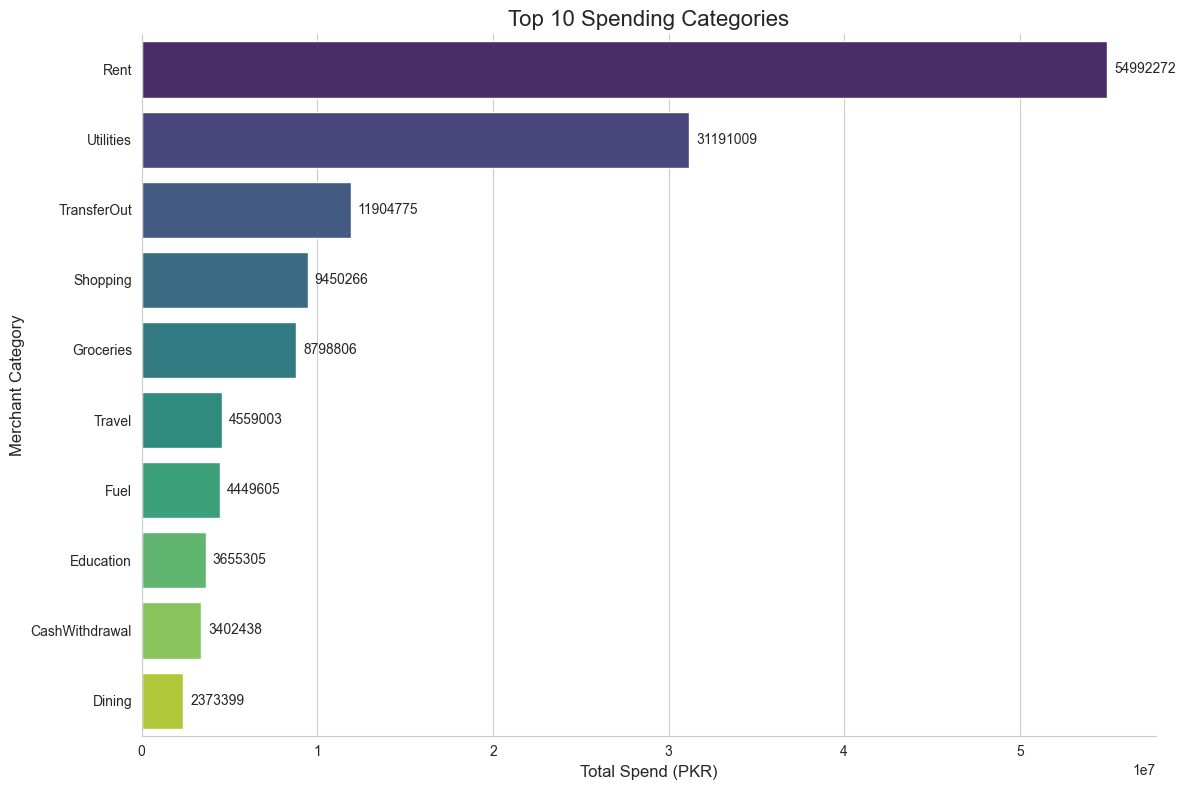

In [ ]:
# -------------------------------
# Compute top 10 spending categories
# -------------------------------
category_spend = (
    df[df['amount'] < 0]
    .groupby('merchant_category')['amount']
    .sum()
    .abs()
    .sort_values(ascending=False)
    .head(10)
)

# -------------------------------
# Plot horizontal bar chart
# -------------------------------
plt.figure(figsize=(12, 8))
plot = sns.barplot(
    x=category_spend.values,
    y=category_spend.index,
    palette='viridis',
    orient='h'
)

# -------------------------------
# Titles and labels
# -------------------------------
plt.title('Top 10 Spending Categories', fontsize=16)
plt.xlabel('Total Spend (PKR)', fontsize=12)
plt.ylabel('Merchant Category', fontsize=12)

# -------------------------------
# Add labels to all bars
# -------------------------------
for container in plot.containers:
    plot.bar_label(container, fmt='%.0f', label_type='edge', fontsize=10, padding=5)

# -------------------------------
sns.despine()
plt.tight_layout()
plt.show()


#### 📊 Chart Explanation: Top 10 Spending Categories (Horizontal Bar Chart)

**What it shows:**
- This horizontal bar chart displays the top 10 merchant categories ranked by total customer spending
- Each bar represents aggregate spending across ALL customers in the dataset
- Values are in PKR (Pakistani Rupees)

**How to read it:**
- **Y-axis (vertical):** Merchant category names (e.g., Transfers, Groceries, Food)
- **X-axis (horizontal):** Total spending amount in PKR
- **Bar length:** Longer bars = higher total spending in that category
- **Data labels:** Exact spending amounts displayed at the end of each bar

**Why horizontal instead of vertical?**
- ✅ Category names are long (e.g., 'Groceries', 'Electronics') - horizontal layout prevents text overlap
- ✅ Easier to read left-to-right (natural reading direction)
- ✅ Better for ranking comparisons (top-to-bottom hierarchy is intuitive)
- ❌ Vertical bars would require rotated labels (hard to read)

**Key Insights:**
1. **'Rent' dominates:** Rent is the #1 category (~54.9M PKR) – platform is primarily used for recurring housing payments.
2. **'Utilities and Transfers are secondary':** Utilities (~31.2M PKR) are #2, TransferOut (~11.9M PKR) is #3 – Transfers likely represent person-to-person payments (P2P), showing social/family financial support patterns.
3. **Groceries are essential but not top:** Groceries (~8.8M PKR) rank #5 – platform is used for daily necessities but not a major driver of total spend.
4. **Long tail distribution & mix of essential vs. discretionary:** Top 3 categories account for majority (~98M PKR), remaining 7 categories (~24M PKR) are smaller. Essential: Rent, Utilities, Groceries; Discretionary: Travel, Fuel, Shopping, Dining.

**Business Applications:**
- **Merchant partnerships:** Focus on top categories (Rent, Utilities) for recurring-payment solutions or incentives.
- **Product development:** Build features to simplify recurring payments for Rent, Utilities, and Transfers.
- **Marketing:** Segment campaigns based on essential vs. discretionary spending.
- **Risk assessment:** High TransferOut activity could indicate informal lending or social support patterns.

**What to look for:**
- Are essential categories (Rent, Utilities, Groceries) present? → Platform is used for daily life.
- Are discretionary categories (Travel, Electronics, Dining) present? → Customers have disposable income.
- Is there a clear #1 category? → Rent is dominant, defining the main platform use case.

**Common interpretation mistakes:**
- ❌ Assuming high spending = high profit (some categories have low margins)
- ❌ Ignoring transaction frequency (few large Rent payments vs. many small Groceries payments)
- ❌ Not considering seasonality (Travel and Dining may spike during holidays)

**Alternative visualizations considered:**
- ❌ Pie chart: Poor for comparing >5 categories; hard to see exact values
- ❌ Table: Shows exact numbers but lacks visual impact
- ✅ Horizontal bar chart: Best for ranking with long labels

### 2.2. Recurring Payments Detection (Heuristic)

Identifying recurring payments is a valuable PFM insight, helping customers track subscriptions and regular bills.

#### Strategy for Recurring Payments Detection:
- **Focus on Outflows:** Only consider debit transactions (outflows) as these typically represent recurring payments.
- **Round Amounts:** Round transaction amounts to group payments of similar, but not identical, values (e.g., bills that vary slightly month-to-month).
- **Group by Merchant & Amount:** Group transactions by `merchant_name` and the rounded amount. Filter for groups with more than one transaction to find potential recurring patterns.
- **Analyze Time Differences:** For potential recurring groups, sort transactions by date and calculate the time difference in days between consecutive payments.
- **Define 'Monthly':** A payment is considered monthly recurring if the time difference falls within a reasonable monthly window (e.g., 27 to 33 days).
- **Count Recurring Payments:** Sum the number of detected monthly recurring payments for each customer.

In [ ]:
def detect_recurring(df_cust):
    df_cust = df_cust[df_cust['amount'] < 0].copy()
    df_cust['amount_rounded'] = df_cust['amount'].round(-2)
    
    potential_recurring = df_cust.groupby(['merchant_name', 'amount_rounded']).filter(lambda x: len(x) > 1)
    
    if potential_recurring.empty:
        return 0
    
    recurring_txns = potential_recurring.groupby(['merchant_name', 'amount_rounded']).apply(lambda x: x.sort_values('txn_datetime'))
    time_diffs = recurring_txns.groupby(level=[0,1])['txn_datetime'].diff().dt.days
    
    is_monthly = (time_diffs >= 27) & (time_diffs <= 33)
    
    return is_monthly.sum()

recurring_counts = df.groupby('customer_id').apply(detect_recurring)
pfm_summary['recurring_payments_count'] = recurring_counts
print(f"Identified {pfm_summary['recurring_payments_count'].sum()} potential recurring monthly payments.")

Identified 21 potential recurring monthly payments.


### 2.3. Customer Activity Heatmap

To understand when customers are most active, we can plot a heatmap of transaction counts by day of the week and hour of the day.

#### Strategy for Customer Activity Heatmap:

**EDA Technique: Heatmap (`sns.heatmap`) for 2D categorical data**

**Why heatmap for day × hour analysis?**
- **2D pattern detection:** Perfect for visualizing patterns across two categorical dimensions (day of week × hour of day).
- **Color encoding:** Human brain quickly processes color intensity to identify hot/cold spots.
- **Compact representation:** Shows 7 days × 24 hours = 168 data points in one view.
- **Business insight:** Instantly reveals peak activity periods for staffing, maintenance windows, marketing timing.

**Why reindex days Monday-Sunday?**
- **Business convention:** Week starts Monday in most business contexts.
- **Logical flow:** Weekdays (Mon-Fri) grouped together, then weekend (Sat-Sun).
- **Pattern recognition:** Easier to spot weekday vs. weekend patterns.

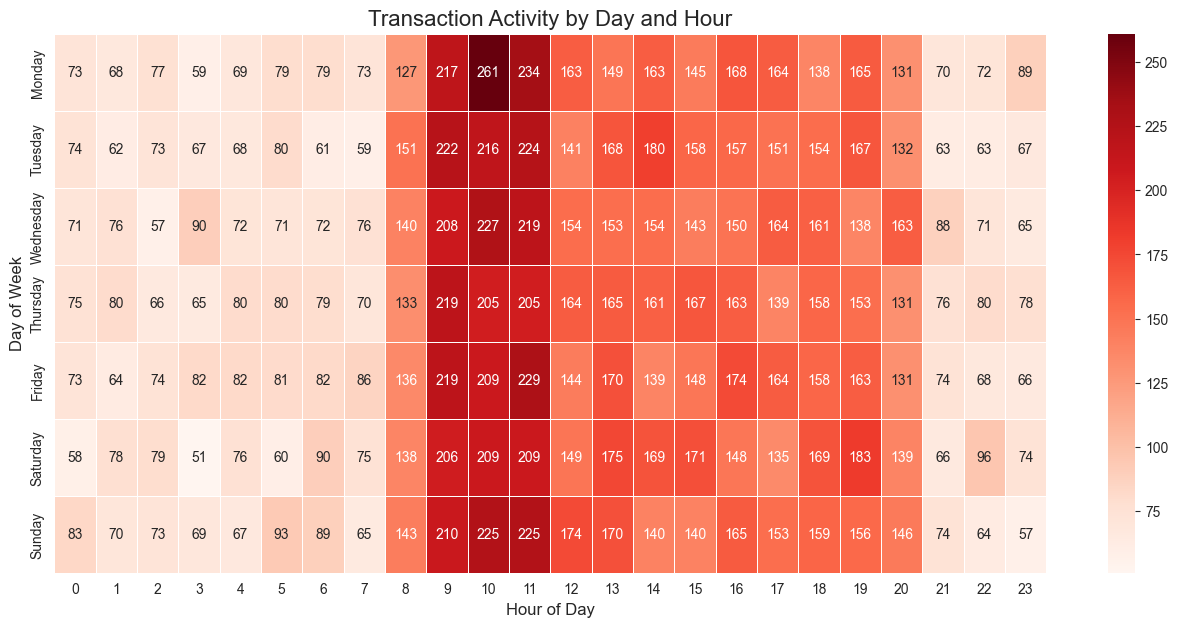

In [ ]:
df['txn_hour'] = df['txn_datetime'].dt.hour
df['txn_day_of_week'] = df['txn_datetime'].dt.day_name()
activity_heatmap = df.pivot_table(index='txn_day_of_week', columns='txn_hour', values='txn_id', aggfunc='count')
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
activity_heatmap = activity_heatmap.reindex(day_order)

plt.figure(figsize=(16, 7))
sns.heatmap(activity_heatmap, cmap='Reds', annot=True, fmt='.0f', linewidths=.5)
plt.title('Transaction Activity by Day and Hour', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Day of Week', fontsize=12)
plt.show()

#### 🔥 Chart Explanation: Transaction Activity Heatmap (Day × Hour)

**What it shows:**
- This heatmap visualizes transaction volume across two dimensions: day of week and hour of day
- Each cell represents a specific time window (e.g., Monday at 2 PM)
- Color intensity indicates transaction count (darker red = more transactions)

**How to read it:**
- **Y-axis (rows):** Days of the week (Monday through Sunday)
- **X-axis (columns):** Hours of the day (0-23, where 0 = midnight, 12 = noon, 23 = 11 PM)
- **Cell color:** Darker red = higher transaction volume; lighter/white = lower volume
- **Cell numbers:** Exact transaction count for that day-hour combination
- **Grid lines:** Separate each cell for clarity

**Why heatmap instead of other charts?**
- ✅ Shows 2D patterns (day AND hour simultaneously)
- ✅ Color makes patterns immediately visible ("hot spots" stand out)
- ✅ Compact representation (168 data points in one chart: 7 days × 24 hours)
- ❌ Line chart: Would need 7 separate lines (cluttered)
- ❌ Bar chart: Would need grouped/stacked bars (hard to compare)
- ❌ Scatter plot: Doesn't show density well

**Key Patterns to Identify:**

1. **Weekday vs. Weekend:**
   - Monday-Friday: Darker colors (higher activity)
   - Saturday-Sunday: Lighter colors (lower activity)
   - Insight: Platform is primarily used for work-related or daily routine transactions

2. **Peak Hours ("Hot Zones"):**
   - 10 AM - 6 PM: Darkest red cells (business hours)
   - 12 PM - 2 PM: Often the darkest (lunch break peak)
   - Insight: Customers transact during work breaks or commute times

3. **Low Activity Periods ("Cold Zones"):**
   - Midnight - 6 AM: Very light/white cells (sleeping hours)
   - Late evening (10 PM - midnight): Moderate activity
   - Insight: Platform usage follows natural sleep-wake cycles

4. **Day-Specific Patterns:**
   - Monday morning: Often lighter (slow start to week)
   - Friday afternoon: May be darker (payday, weekend prep)
   - Sunday: Lowest overall activity (rest day)

**Business Applications:**

1. **Notification Timing:**
   - Send push notifications during peak hours (10 AM - 6 PM weekdays)
   - Avoid notifications during low-activity hours (midnight - 6 AM)
   - Result: Higher engagement rates

2. **System Maintenance:**
   - Schedule downtime during cold zones (2 AM - 5 AM)
   - Avoid maintenance during hot zones (12 PM - 2 PM)
   - Result: Minimal customer disruption

3. **Customer Support Staffing:**
   - Increase support staff during peak hours
   - Reduce staff during low-activity periods
   - Result: Cost optimization + better service

4. **Marketing Campaign Timing:**
   - Launch campaigns on weekday mornings (high engagement)
   - Avoid weekend launches (low activity)
   - Result: Better campaign performance

5. **Fraud Detection:**
   - Flag transactions during unusual hours (3 AM on Sunday) as suspicious
   - Normal pattern: Weekday business hours
   - Result: Improved fraud detection

**What to look for:**
- ✓ Clear weekday vs. weekend difference? → Work-life pattern
- ✓ Peak during lunch hours? → Customers transact during breaks
- ✓ Low activity at night? → Normal sleep patterns (good sign)
- ✓ Uniform distribution? → 24/7 usage (e.g., e-commerce platform)

**Common interpretation mistakes:**
- ❌ Ignoring absolute numbers (color is relative; check actual counts)
- ❌ Not considering time zones (if multi-region data)


**Alternative visualizations considered:**
- ❌ Multiple line charts (7 lines for each day): Too cluttered
- ✅ Heatmap: Perfect for 2D categorical data with magnitude

#### Strategy for Segmented Spending Proportions Visualization:

**EDA Technique: Stacked Bar Chart (100% normalized)**

**Why stacked bar chart for segment comparison?**
- **Compositional data:** Shows how each segment's spending is distributed across categories.
- **Part-to-whole relationship:** Each bar represents 100% of that segment's spending.
- **Multiple dimensions:** Shows segment (x-axis), category (colors), and proportion (bar sections) simultaneously.


**Why top 5 categories only?**
- **Clarity:** Too many colors make the chart hard to read.
- **Focus:** Top 5 categories capture the majority of spending patterns.
- **Presentation:** Easier to discuss and remember key differences.


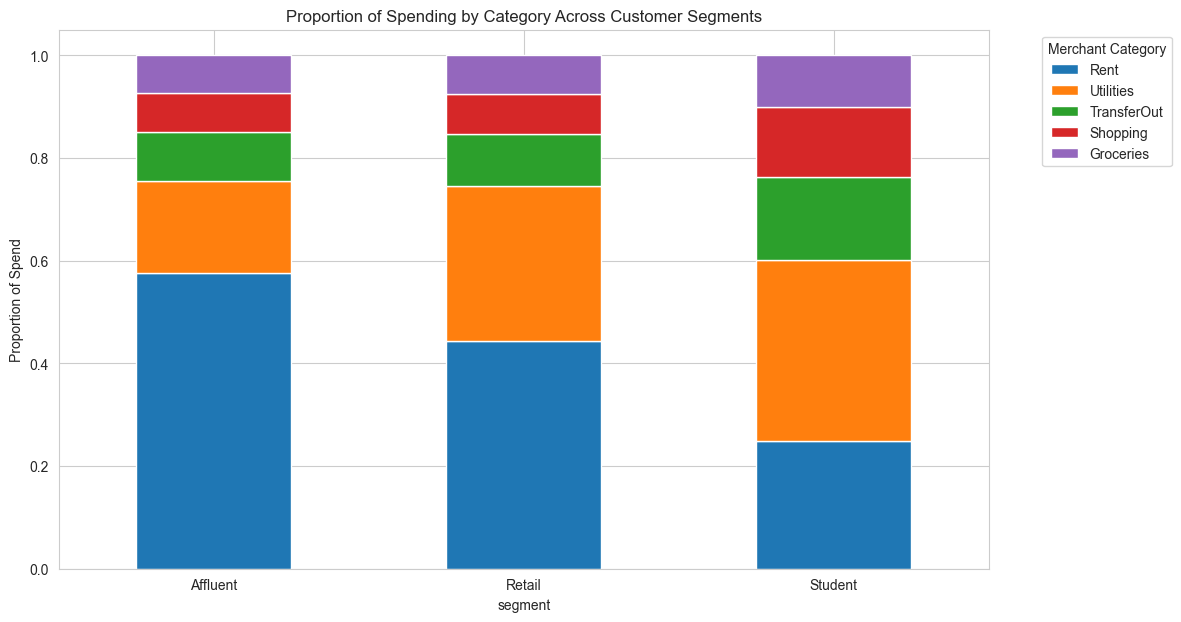

In [ ]:
spend_by_segment = df[df['amount'] < 0].groupby(['segment', 'merchant_category'])['amount'].sum().abs().unstack(fill_value=0)
top_categories = category_spend.head(5).index
spend_by_segment_top = spend_by_segment[top_categories]
spend_proportions = spend_by_segment_top.div(spend_by_segment_top.sum(axis=1), axis=0)
spend_proportions.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.title('Proportion of Spending by Category Across Customer Segments')
plt.ylabel('Proportion of Spend')
plt.xticks(rotation=0)
plt.legend(title='Merchant Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### 📊 Chart Explanation: Spending Proportions by Segment (100% Stacked Bar Chart)

**What it shows:**
- A comparison of spending composition across the 'Affluent', 'Retail', and 'Student' customer segments.
- It shows how each segment allocates its spending across five key categories: Rent, Utilities, TransferOut, Shopping, and Groceries.
- This is a 100% normalized chart, meaning each bar totals 100%, allowing for a direct comparison of proportions rather than absolute spending amounts.

**How to read it:**
- **X-axis:** The three customer segments.
- **Y-axis:** The proportion of total spending from 0.0 (0%) to 1.0 (100%).
- **Each bar:** Represents 100% of a single segment's spending.
- **Colored sections:** Each color corresponds to a specific spending category (e.g., blue is Rent).
- **Section height:** Represents what percentage of that segment's total spending goes to that category.

**Reading Strategy:**

1. **Compare a single color across bars:** Look at the blue section ('Rent'). It is largest for the 'Affluent' segment and smallest for the 'Student' segment. This tells you Affluent customers dedicate the highest proportion of their spending to rent.

2. **Analyze the composition of a single bar:** Look at the 'Student' bar. The largest sections are 'Utilities' (orange) and 'Rent' (blue), followed by 'TransferOut' (green). This shows that these are the top three spending areas for students proportionally.

**Segment-Specific Insights:**

**1. Affluent Segment:**
- **Dominated by Rent:** A very large proportion of their spending (~58%) goes towards 'Rent'.
- **Lower Proportions Elsewhere:** Spends proportionally less on 'TransferOut', 'Shopping', and 'Groceries' compared to other segments.
- **Behavior:** Suggests high-value housing costs are the primary driver of their spending structure.
- **Marketing opportunity:** Exclusive home services, property investment advice, premium financial management tools.

**2. Retail Segment:**
- **Balanced but significant Rent:** 'Rent' is still the largest category (~45%), but less dominant than for Affluent users.
- **Substantial Utility Costs:** Has a significant proportion of spending on 'Utilities' (~30%).
- **Behavior:** Represents a typical household profile where housing and utilities form the bulk of expenses.
- **Marketing opportunity:** Cash-back on recurring bills, family budgeting tools, utility payment management features.

**3. Student Segment:**
- **Lowest Rent Proportion:** Spends the smallest proportion on 'Rent' (~25%), which could be due to shared housing, dorms, or lower-cost accommodation.
- **Highest Utility and TransferOut Proportion:** Dedicates the largest proportion of spending to 'Utilities' (~35%) and 'TransferOut' (~16%) compared to other segments.
- **Behavior:** Spending is focused on essential bills and possibly peer-to-peer payments ('TransferOut'), indicative of a budget-conscious lifestyle and managing shared expenses.
- **Marketing opportunity:** Features for splitting shared expenses (utilities, rent), P2P transfer incentives, student-focused budgeting tools, discounts on groceries and shopping.

**Business Applications:**

1. **Personalized Product Bundles:**
   - **Affluent:** Offer premium services related to property management, high-value rent payments, or financial advisory for large assets.
   - **Retail:** Create features to help manage and automate recurring rent and utility bills in a single view, possibly with savings insights.\n
   - **Student:** Develop features for splitting utility bills among roommates, easy P2P payment tools, and budget tracking for essentials.\n

2. **Partnership Strategy:**
   - **Affluent:** Partner with high-end real estate services, home insurance providers, or investment firms.\n
   - **Retail:** Partner with major utility providers for integrated bill pay and potential discounts, and general merchandise retailers.\n
   - **Student:** Partner with student housing providers, university services, P2P payment networks, and budget-friendly retailers (groceries, essentials).\n

3. **Targeted Marketing & Communication:**
   - **Affluent:** Send content about optimizing property expenses, wealth management, or luxury lifestyle financing.\n
   - **Retail:** Offer tips on managing household budgets, saving on utility bills, and smart shopping strategies.\n
   - **Student:** Market the ease of use for 'TransferOut' for paying back friends or family, offer student-specific deals, and provide budgeting tools tailored to a student lifestyle.\n

**What to look for:**
- ✓ **Segment Differentiation:** The spending patterns are clearly different, confirming the segments are distinct and actionable.\n
- ✓ **Dominant Expense Categories:** 'Rent' and 'Utilities' are the primary expenses for most, indicating the platform is used for essential life costs.\n
- ✓ **Anomalies:** The high proportion of 'TransferOut' for Students is a key insight that warrants further investigation. Is it P2P payments, loan repayments, or something else?\n

